In [114]:
import os
import io
import gc
import sys
import yaml
import json
import time
import glob
import wave
import faiss
import pickle

import random
import librosa

import numpy as np
import pandas as pd
import deepdish as dd
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from model_RA.fp_RA.nnfp import get_fingerprinter
from model_RA.fp_RA.melspec.melspectrogram_RA import get_melspec_layer

# **Carregar Faiss Index**

In [2]:
def create_index(db_embeddings, nogpu=True, n_centroids=256, code_sz=64, nbits=8):
    #faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits), com d=, nlist=n_centroids=50, m=code_sz=8, bits=nbits=8
    #faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)
    #n_centroids -> clusters

    # GPU Setup
    if not nogpu:
        GPU_RESOURCES = faiss.StandardGpuResources()
        GPU_OPTIONS = faiss.GpuClonerOptions()
        GPU_OPTIONS.useFloat16 = True # use float16 table to avoid https://github.com/facebookresearch/faiss/issues/1178
    else:
        pass
    

    # Fingerprint dimension, d
    d = db_embeddings.shape[1] #len(db_embeddings[0][0]) #db_embeddings.shape[1]  # Dim emb #len(db_embeddings[0][0][0])


    # Build a flat (CPU) index
    quantizer = faiss.IndexFlatL2(d)


    # Using IVF-PQ index
    code_sz = 64 # power of 2
    n_centroids = 256 # Number of Veronoi Cells (?)
    nbits = 8  # nbits must be 8, 12 or 16, The dimension d should be a multiple of M.
    index = faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits) #Adicona clustering


    # Se não usar GPU
    if not nogpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    max_nitem_train = int(1e7)
    # Train index
    if not index.is_trained:
        #print('Training index using {:>3.2f} % of data...'.format(100. * max_nitem_train / len(db_embeddings)))
        #sel_tr_idx = np.random.permutation(len(db_embeddings))
        #sel_tr_idx = sel_tr_idx[:max_nitem_train]
        #index.train(db_embeddings[sel_tr_idx,:])
        index.train(db_embeddings)
    

    # N probe
    index.nprobe = 40
    return index

# **Carregar Base de Dados**

In [3]:
def load_memmap_data(source_dir,
                     fname,
                     append_extra_length=None,
                     shape_only=False,
                     display=True):
    """
    Load data and datashape from the file path.

    • Get shape from [source_dir/.npy}.
    • Load memmap data from [source_dir/fname.mm].

    Parameters
    ----------
    source_dir : (str)
    fname : (str)
        File name except extension.
    append_empty_length : None or (int)
        Length to appened empty vector when loading memmap. If activate, the
        file will be opened as 'r+' mode.
    shape_only : (bool), optional
        Return only shape. The default is False.
    display : (bool), optional
        The default is True.

    Returns
    -------
    (data, data_shape)

    """
    path_shape = source_dir + fname + '_shape.npy'
    path_data = source_dir + fname + '.mm'
    data_shape = np.load(path_shape)
    if shape_only:
        return data_shape

    if append_extra_length:
        data_shape[0] += append_extra_length
        data = np.memmap(path_data, dtype='float32', mode='r+',
                         shape=(data_shape[0], data_shape[1]))
    else:
        data = np.memmap(path_data, dtype='float32', mode='r',
                         shape=(data_shape[0], data_shape[1]))
    if display:
        print(f'Load {data_shape[0]:,} items from \033[32m{path_data}\033[0m.')
    return data, data_shape

In [4]:
emb_dir = '/mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/'
emb_dummy_dir = None

In [5]:
# Load items from {query, db, dummy_db}
query, query_shape = load_memmap_data(emb_dir, 'query')
db, db_shape = load_memmap_data(emb_dir, 'db')
if emb_dummy_dir is None:
    emb_dummy_dir = emb_dir
dummy_db, dummy_db_shape = load_memmap_data(emb_dummy_dir, 'dummy_db')

Load 29,500 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/query.mm.
Load 29,500 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/db.mm.
Load 53,754,198 items from /mnt/dev/rodrigoalmeida/neural-audio-fp/logs/emb/CHECK_BFTRI_100/101/dummy_db.mm.


In [6]:
max_nitem_train = int(1e7)
print('Training index using {:>3.2f} % of data...'.format(100. * max_nitem_train / len(dummy_db)))
sel_tr_idx = np.random.permutation(len(dummy_db))
sel_tr_idx = sel_tr_idx[:max_nitem_train]

Training index using 18.60 % of data...


In [7]:
dummy_db_sliced = dummy_db[sel_tr_idx,:]

In [8]:
%%time
faiss_engine = create_index(dummy_db_sliced, nogpu=True, n_centroids=256, code_sz=64, nbits=8) #dummy_db

CPU times: user 38min 40s, sys: 5.47 s, total: 38min 46s
Wall time: 6min 4s


In [9]:
del dummy_db_sliced
faiss_engine.add(dummy_db); print(f'{len(dummy_db)} items from dummy DB')
faiss_engine.add(db); print(f'{len(db)} items from reference DB')

# Adicionados os embeddings ao índice
print(f"Foram adicionados:{faiss_engine.ntotal}")

53754198 items from dummy DB
29500 items from reference DB
Foram adicionados:53783698


In [10]:
del dummy_db
fake_recon_index, index_shape = load_memmap_data(
    emb_dummy_dir, 'dummy_db', append_extra_length=query_shape[0],
    display=False)

fake_recon_index[dummy_db_shape[0]:dummy_db_shape[0] + query_shape[0], :] = db[:, :]
fake_recon_index.flush()

# **Procura no Faiss**

Vou buscar o comprimento dos db aos h5 e vou saber qual o len de cada file. Depois somo isso ao db_memmap

In [ ]:
start = 0
sl = 5

db_startIndex = 53754198

counter_5seg = 0

#dbsmall = db[:80]

true_labels = []  # Lista para armazenar os rótulos verdadeiros
predicted_labels = []  # Lista para armazenar os rótulos previstos

for start in range(len(db)):
    print(start)
    q = db[start:start+sl,:]
    _, I = faiss_engine.search(q, 20) # D: Distâncias, I: Índices dos resultados
    print(I)
    
    for offset in range(len(I)):
        I[offset, :] -= offset

In [115]:
## Guardar num ficheiro pkl cada segemento com os 100 indíces correspondentes
output_pkl = "/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/"

In [116]:
step_memmap = []

source_dir_db = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dbEmb/'
h5Files_db = sorted(glob.glob(os.path.join(source_dir_db, '**/*.h5') ,recursive = True))

In [117]:
for idx_file, file in enumerate(h5Files_db):
    len_file = len(dd.io.load(file))
    step_memmap.append([idx_file, len_file])

In [118]:
len(step_memmap)

500

In [ ]:
%%time
#34min 31s
inicio_memmap = 0
final_memmap = 0

for i, idxlen in enumerate(step_memmap):

    aux_step_memmap = idxlen[1]
    inicio_memmap = aux_step_memmap*i
    final_memmap = inicio_memmap + aux_step_memmap


    emb = db[inicio_memmap:final_memmap]
    _, I = faiss_engine.search(emb, 100) # D: Distâncias, I: Índices dos resultados
    

    #Guardar no ficheiro
    base_name = os.path.splitext(os.path.basename(h5Files_db[i]))[0]
    file_name_pkl = output_pkl + base_name + ".pkl"
    with open(file_name_pkl, 'wb') as file_pkl:
        pickle.dump(I, file_pkl)
        print(file_pkl)

# **Ler ficheiros pkl**

In [208]:
input_pkl = "/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/"
pklFiles_db = sorted(glob.glob(os.path.join(input_pkl, '*.pkl') ,recursive = True))

In [209]:
len(pklFiles_db)

500

In [318]:
inicio_valor = 53783698-29500 # 53754198
presencas = []
posicoes = []

In [ ]:
for idx_file, file in enumerate(pklFiles_db[:2]):
    with open(file, 'rb') as file_pkl:
            print(file_pkl)
            I = pickle.load(file_pkl)

    """
            for offset in range(len(I)):
                I[offset, :] -= offset

        
            #candidates = np.unique(I[np.where(I >= 0)])   # ignore id < 0


            aux_step_memmap = step_memmap[idx_file][1]
            inicio_memmap = aux_step_memmap*idx_file
            final_memmap = inicio_memmap + aux_step_memmap
            q = db[inicio_memmap:final_memmap]


            # Sequence match score - Similaridade cosseno
            _scores = np.zeros((len(I), 100))
            for iI in range(len(I)):
                for ci in range(len(I[iI])):

                    _scores[iI][ci] = np.mean(
                        np.diag(
                            np.dot(q, fake_recon_index[I[iI][ci]:I[iI][ci] + len(I), :].T)
                            )
                        )
                    print( _scores[iI][ci])


                
            #pred_ids = I[np.argsort(-_scores)]
            #print(pred_ids)"""

In [319]:
for idx_file, file in enumerate(pklFiles_db):
    with open(file, 'rb') as file_pkl:
            print(file_pkl)
            I = pickle.load(file_pkl)
        
            inicio = inicio_valor + len(I) * idx_file  #inicio = 53754198+59*0 --- 53754198+59*1 --- 53754198+59*2 --- 53754198+59*3
            final = inicio + len(I) # final = 53754198+59 --- 53754198+59+59
            ground_truth = list(range(inicio, final))
            #print(ground_truth)

            #print(f"INICIO-{inicio_valor}-{inicio}")

            for idx_segmento, segmento in enumerate(I):
                #print(segmento)
                ground_truth_id = ground_truth[idx_segmento]

                if ground_truth_id in segmento:  # Verifica nos 100 índices retornados
                    presencas.append(True)

                    posicao = segmento.tolist().index(ground_truth_id)
                    #print(posicao)
                    posicoes.append(posicao)
                else:
                    presencas.append(False)
                    posicoes.append(-1)

<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/000134.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/000512.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/000760.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/000768.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/000776.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/001018.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/001028.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/001042.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/001043.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/001108.pkl'>
<_io.BufferedReader name='/mnt/dataset/public/Fingerprinting/pkl_idxFaiss/001118.pkl'>
<_io.BufferedReader name='/mnt/dataset/publ

In [320]:
sum(presencas) / len(presencas), len(posicoes)

(1.0, 29500)

In [325]:
count_0 = count_1 = count_2 = count_3 = count_4 = count_5 = 0

for i in range(len(posicoes)):
    if posicoes[i]  == 0:
        count_0 += 1

    if posicoes[i] == 1:
        count_1 += 1

    if posicoes[i] == 2:
        count_2 += 1
    
    if posicoes[i] == 3:
        count_3 += 1

    if posicoes[i] == 4:
        count_4 += 1

    if posicoes[i] == 5:
        count_5 += 1

print(count_0, count_1, count_2, count_3, count_4, count_5)

29258 242 0 0 0 0


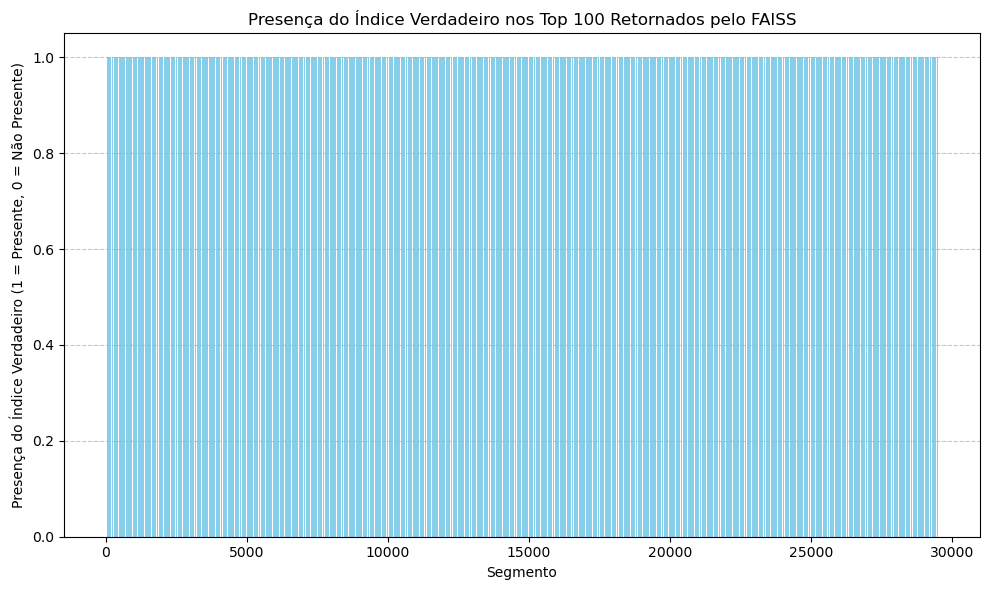

In [322]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(presencas)), presencas, color='skyblue')
plt.xlabel('Segmento')
plt.ylabel('Presença do Índice Verdadeiro (1 = Presente, 0 = Não Presente)')
plt.title('Presença do Índice Verdadeiro nos Top 100 Retornados pelo FAISS')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('indice_verdadeiro_presenca_histograma.png')
plt.show()

In [326]:
sl = len(I)
slDir = 'length_full_59-bd_db-kprobe_100/'
posImageDir = "/mnt/dev/rodrigoalmeida/neural-audio-fp/Imagens_predict/" + slDir

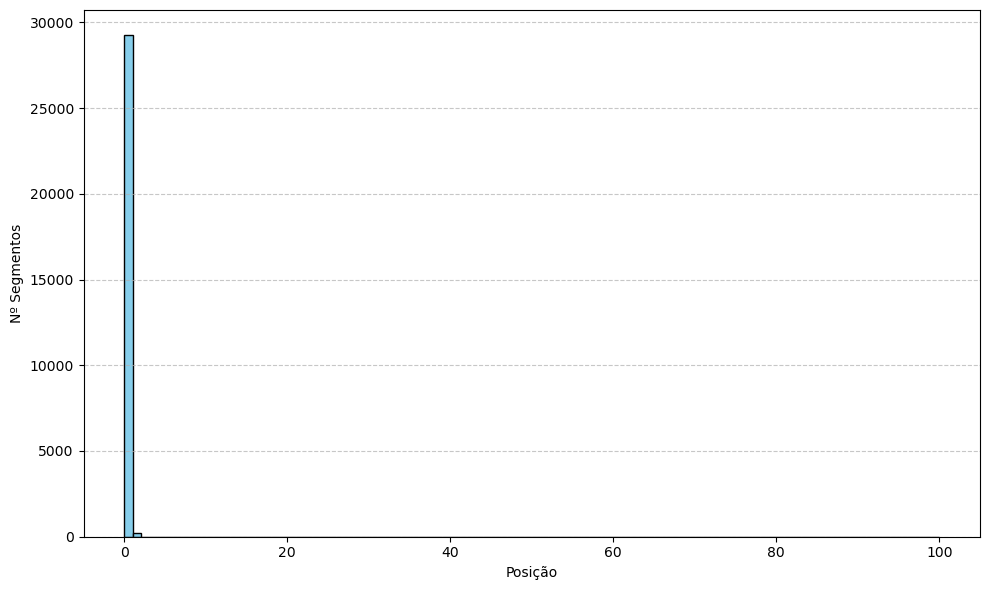

In [327]:
nome_fig = posImageDir + 'Posicao_histograma_db_sl_%d.png' % sl

posicoes_validas = [p for p in posicoes if p != -1]  # Excluir posições -1 (não encontradas)
plt.figure(figsize=(10, 6))
plt.hist(posicoes_validas, bins=range(101), color='skyblue', edgecolor='black')
plt.xlabel('Posição')
plt.ylabel('Nº Segmentos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(nome_fig)
plt.show()